In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/My Drive/My Drive/StokesData_Hackthon/RELIANCE.csv', parse_dates=['Date'], index_col='Date')

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-01,1179.222168,1191.604736,1174.269043,1181.153809,1166.502197,9796282
2018-08-02,1180.311768,1180.311768,1155.001709,1157.379150,1143.022461,6308209
2018-08-03,1163.966797,1172.386963,1158.567993,1165.898438,1151.436035,6708388
2018-08-06,1165.650757,1184.769531,1164.313477,1181.401489,1166.746826,4054489
2018-08-07,1183.679932,1190.118896,1165.947998,1173.080322,1158.528931,4097939


<Axes: xlabel='Date'>

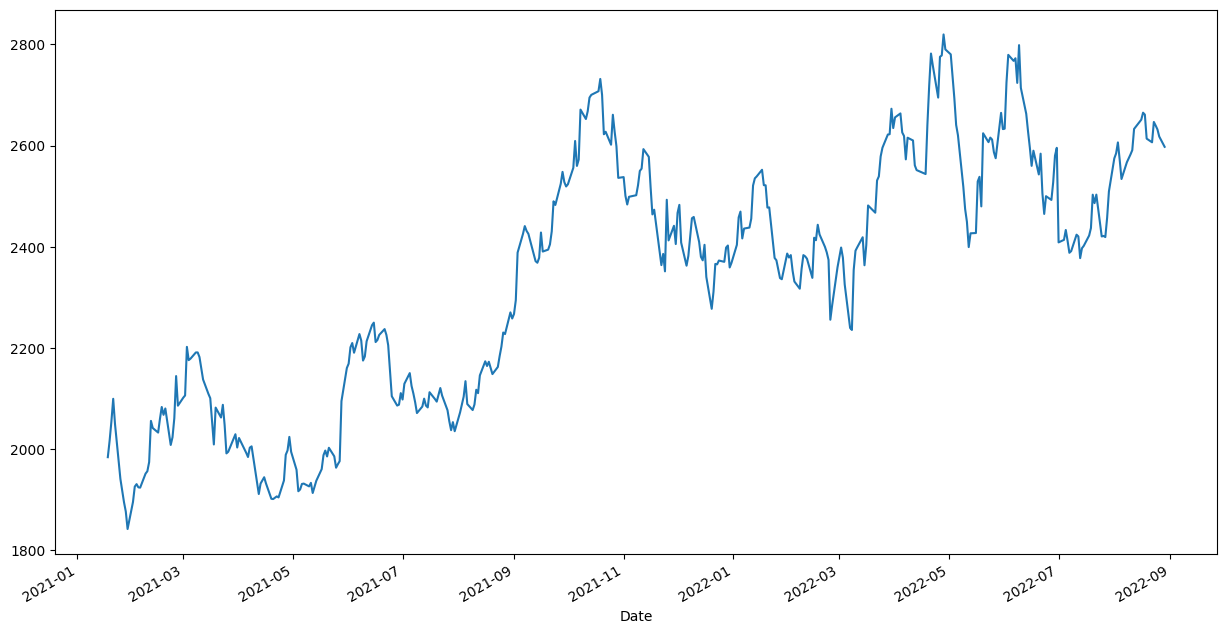

In [ ]:
data[-400:].Close.plot(figsize =(15,8))

The above graph shows the closing price for last 400 Trading sessions. 

### Golden CrossOver
if sma20 crosses sma50 then it is a signal of buy, otherwise sell. 


In [ ]:
data['20_SMA'] = data.Close.rolling(window=20, min_periods=1).mean()
data['50_SMA'] = data.Close.rolling(window=50, min_periods=1).mean()

In [ ]:
data['Signal'] = 0
data['Signal'] = np.where(data['20_SMA'] > data['50_SMA'], 1, 0)

In [ ]:
data['Position'] = data.Signal.diff()

In [ ]:
def GoldenCrossverSignal(name, data_point):
    path = f'/content/drive/MyDrive/My Drive/My Drive/StokesData_Hackthon/{name}.csv'
    data = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
    data['20_SMA'] = data.Close.rolling(window=20, min_periods=1).mean()
    data['50_SMA'] = data.Close.rolling(window=50, min_periods=1).mean()
    data['Signal'] = 0
    data['Signal'] = np.where(data['20_SMA'] > data['50_SMA'], 1, 0)
    data['Position'] = data.Signal.diff()
    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data.iloc[-data_point:]['Close'].plot(color = 'k', label= 'Close Price') 
    data.iloc[-data_point:]['20_SMA'].plot(color = 'b',label = '20-day SMA') 
    data.iloc[-data_point:]['50_SMA'].plot(color = 'g', label = '50-day SMA')
    # plot ‘buy’ signals
    plt.plot(data.iloc[-data_point:][data.iloc[-data_point:]['Position'] == 1].index, 
             data.iloc[-data_point:]['20_SMA'][data.iloc[-data_point:]['Position'] == 1], 
             '^', markersize = 15, color = 'g', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(data.iloc[-data_point:][data.iloc[-data_point:]['Position'] == -1].index, 
             data.iloc[-data_point:]['20_SMA'][data.iloc[-data_point:]['Position'] == -1], 
             'v', markersize = 15, color = 'r', label = 'sell')
    plt.ylabel('Price in Rupees', fontsize = 15 )
    plt.xlabel('Date', fontsize = 15 )
    plt.title(name, fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()
    df_pos = data.iloc[-data_point:][(data.iloc[-data_point:]['Position'] == 1) | (data['Position'] == -1)].copy()
    df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
    print(tabulate(df_pos[['Close', 'Position']], headers = 'keys', tablefmt = 'psql'))

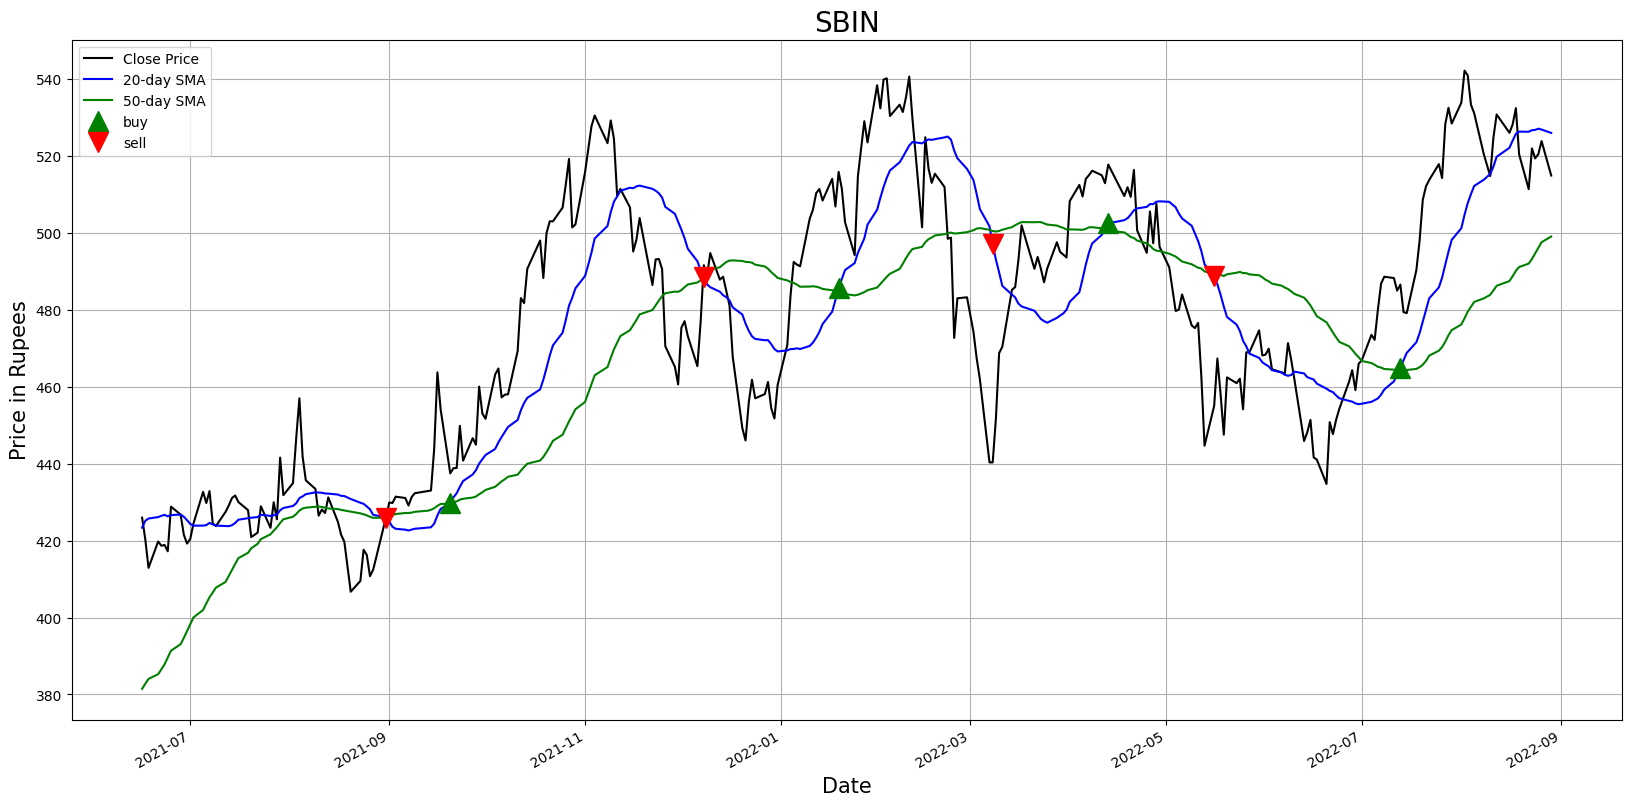

+---------------------+---------+------------+
| Date                |   Close | Position   |
|---------------------+---------+------------|
| 2021-08-31 00:00:00 |  426.05 | Sell       |
| 2021-09-20 00:00:00 |  437.45 | Buy        |
| 2021-12-08 00:00:00 |  491.55 | Sell       |
| 2022-01-19 00:00:00 |  515.8  | Buy        |
| 2022-03-08 00:00:00 |  440.3  | Sell       |
| 2022-04-13 00:00:00 |  517.7  | Buy        |
| 2022-05-16 00:00:00 |  455    | Sell       |
| 2022-07-13 00:00:00 |  486.5  | Buy        |
+---------------------+---------+------------+


<ipython-input-24-cf4cd04fab4e>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pos = data.iloc[-data_point:][(data.iloc[-data_point:]['Position'] == 1) | (data['Position'] == -1)].copy()


In [ ]:
GoldenCrossverSignal('SBIN', 300)

## Backtesting SBIN

In [31]:
def GoldenCrossverSignal(name):
    path = f'/content/drive/MyDrive/My Drive/My Drive/StokesData_Hackthon/{name}.csv'
    data = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
    data['Prev_Close'] = data.Close.shift(1)
    data['20_SMA'] = data.Prev_Close.rolling(window=20, min_periods=1).mean()
    data['50_SMA'] = data.Prev_Close.rolling(window=50, min_periods=1).mean()
    data['Signal'] = 0
    data['Signal'] = np.where(data['20_SMA'] > data['50_SMA'], 1, 0)
    data['Position'] = data.Signal.diff()
    df_pos = data[(data['Position'] == 1) | (data['Position'] == -1)].copy()
    df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
    return df_pos

In [32]:
data = GoldenCrossverSignal('SBIN')

In [33]:
required_df = data[(data.index >= data[data['Position'] == 'Buy'].index[0]) & (data.index <= data[data['Position'] == 'Sell'].index[-1])]

In [38]:
class Backtest:
    def __init__(self):
        self.columns = ['Equity Name', 'Trade', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'Quantity', 'Position Size', 'PNL', '% PNL']
        self.backtesting = pd.DataFrame(columns=self.columns)

    def buy(self, equity_name, entry_time, entry_price, qty):
        self.trade_log = dict(zip(self.columns, [None] * len(self.columns)))
        self.trade_log['Trade'] = 'Long Open'
        self.trade_log['Quantity'] = qty
        self.trade_log['Position Size'] = round(self.trade_log['Quantity'] * entry_price, 3)
        self.trade_log['Equity Name'] = equity_name
        self.trade_log['Entry Time'] = entry_time
        self.trade_log['Entry Price'] = round(entry_price, 2)

    def sell(self, exit_time, exit_price, exit_type, charge):
        self.trade_log['Trade'] = 'Long Closed'
        self.trade_log['Exit Time'] = exit_time
        self.trade_log['Exit Price'] = round(exit_price, 2)
        self.trade_log['Exit Type'] = exit_type
        self.trade_log['PNL'] = round((self.trade_log['Exit Price'] - self.trade_log['Entry Price']) * self.trade_log['Quantity'] - charge, 3)
        self.trade_log['% PNL'] = round((self.trade_log['PNL'] / self.trade_log['Position Size']) * 100, 3)
        self.trade_log['Holding Period'] = exit_time - self.trade_log['Entry Time']
        self.backtesting = self.backtesting.append(self.trade_log, ignore_index=True)

    def stats(self):
        df = self.backtesting
        parameters = ['Total Trade Scripts', 'Total Trade', 'PNL',  'Winners', 'Losers', 'Win Ratio','Total Profit', 'Total Loss', 'Average Loss per Trade', 'Average Profit per Trade', 'Average PNL Per Trade', 'Risk Reward']
        total_traded_scripts = len(df['Equity Name'].unique())
        total_trade = len(df.index)
        pnl = df.PNL.sum()
        winners = len(df[df.PNL > 0])
        loosers = len(df[df.PNL <= 0])
        win_ratio = str(round((winners/total_trade) * 100, 2)) + '%'
        total_profit = round(df[df.PNL > 0].PNL.sum(), 2)
        total_loss  = round(df[df.PNL <= 0].PNL.sum(), 2)
        average_loss_per_trade = round(total_loss/loosers, 2)
        average_profit_per_trade = round(total_profit/winners, 2)
        average_pnl_per_trade = round(pnl/total_trade, 2)
        risk_reward = f'1:{-1 * round(average_profit_per_trade/average_loss_per_trade, 2)}'
        data_points = [total_traded_scripts,total_trade,pnl,winners, loosers, win_ratio, total_profit, total_loss, average_loss_per_trade, average_profit_per_trade, average_pnl_per_trade, risk_reward]
        data = list(zip(parameters,data_points ))
        print(tabulate(data, ['Parameters', 'Values'], tablefmt='psql'))

In [36]:

import warnings
warnings. simplefilter(action='ignore', category=Warning)
bt = Backtest()
capital = 50000
for index, data in required_df.iterrows():
    if(data.Position == 'Buy'):
        qty = capital // data.Open
        bt.buy('RELIANCE', index, data.Open, qty)
    else:
        bt.sell(index, data.Open, 'Exit Trigger', 0)

In [37]:
bt.backtesting

,Equity Name,Trade,Entry Time,Entry Price,Exit Time,Exit Price,Quantity,Position Size,PNL,% PNL,Exit Type,Holding Period
0,RELIANCE,Long Closed,2018-09-03,312.50,2018-09-11,287.35,160.0,50000.000,-4024.00,-8.048,Exit Trigger,8 days
1,RELIANCE,Long Closed,2018-11-20,285.90,2019-02-08,285.60,174.0,49746.599,-52.20,-0.105,Exit Trigger,80 days
2,RELIANCE,Long Closed,2019-03-27,305.25,2019-08-02,315.55,163.0,49755.750,1678.90,3.374,Exit Trigger,128 days
3,RELIANCE,Long Closed,2019-11-07,318.25,2020-01-21,313.80,157.0,49965.250,-698.65,-1.398,Exit Trigger,75 days
4,RELIANCE,Long Closed,2020-06-24,194.80,2020-09-30,185.05,256.0,49868.801,-2496.00,-5.005,Exit Trigger,98 days
5,RELIANCE,Long Closed,2020-11-06,219.00,2021-04-08,361.00,228.0,49932.000,32376.00,64.840,Exit Trigger,153 days
6,RELIANCE,Long Closed,2021-05-24,417.00,2021-09-01,427.50,119.0,49623.000,1249.50,2.518,Exit Trigger,100 days
7,RELIANCE,Long Closed,2021-09-21,440.15,2021-12-09,492.30,113.0,49736.949,5892.95,11.848,Exit Trigger,79 days
8,RELIANCE,Long Closed,2022-01-20,516.00,2022-03-09,442.00,96.0,49536.000,-7104.00,-14.341,Exit Trigger,48 days
9,RELIANCE,Long Closed,2022-04-18,512.00,2022-05-17,458.30,97.0,49664.000,-5208.90,-10.488,Exit Trigger,29 days


In [39]:
bt = Backtest()
capital = 50000
# this are some nifty 50 stokes 
scripts = ['RELIANCE', "TCS", 'INFY', 'SBIN', 'HDFCBANK', 'HDFC', 'TITAN', 'HEROMOTOCO', 'TATAMOTORS', 'BPCL']
for stock in scripts:
    data = GoldenCrossverSignal(stock)
    required_df = data[(data.index >= data[data['Position'] == 'Buy'].index[0]) & (data.index <= data[data['Position'] == 'Sell'].index[-1])]
    for index, data in required_df.iterrows():
        if(data.Position == 'Buy'):
            qty = capital // data.Open
            bt.buy(stock, index, data.Open, qty)
        else:
            bt.sell(index, data.Open, 'Exit Trigger', 0)

In [40]:
df = bt.backtesting

In [41]:
bt.stats()

+--------------------------+--------------------+
| Parameters               | Values             |
|--------------------------+--------------------|
| Total Trade Scripts      | 10                 |
| Total Trade              | 105                |
| PNL                      | 240464.62000000002 |
| Winners                  | 41                 |
| Losers                   | 64                 |
| Win Ratio                | 39.05%             |
| Total Profit             | 442995.4           |
| Total Loss               | -202530.78         |
| Average Loss per Trade   | -3164.54           |
| Average Profit per Trade | 10804.77           |
| Average PNL Per Trade    | 2290.14            |
| Risk Reward              | 1:3.41             |
+--------------------------+--------------------+
